In [1]:
import alborexdata
import netCDF4
import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
import numpy as np
import datetime
import cmocean
from importlib import reload

## Configuration

In [2]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

Domain

In [3]:
coordinates = config["domain"]["coordinates1"]
coordinates2 = config["domain"]["coordinates2"]

In [4]:
datafile = config["datafiles"]["adcp"]
os.path.exists(datafile)
figdir = "../figures/ADCP/"

Front

In [5]:
frontcoords = config["datafiles"]["front"]
f = alborexdata.Front()
f.get_from_file(frontcoords)
f.smooth()

## Data reading and quality control

In [6]:
adcp = alborexdata.Adcp()
adcp.get_from_netcdf(datafile)
adcp.apply_qc(qf=1)
adcp.get_norm()

/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py:617: RuntimeWarning: invalid value encountered in sqrt
  self.velnorm = np.sqrt(self.u * self.u + self.v * self.v)


## Figures
### Projection

In [7]:
m = Basemap(projection='merc', llcrnrlon=coordinates2[0], llcrnrlat=coordinates2[2],
            urcrnrlon=coordinates2[1], urcrnrlat=coordinates2[3],
            lat_ts=0.5 * (coordinates2[2] + coordinates2[3]), resolution='h')

### Quiver plot all depths
Plot the velocity fields with arrows.     
The arrow lengths are all the same but the color change, so the visualisation of both the direction and the intensity is easier. No quiver key is needed.

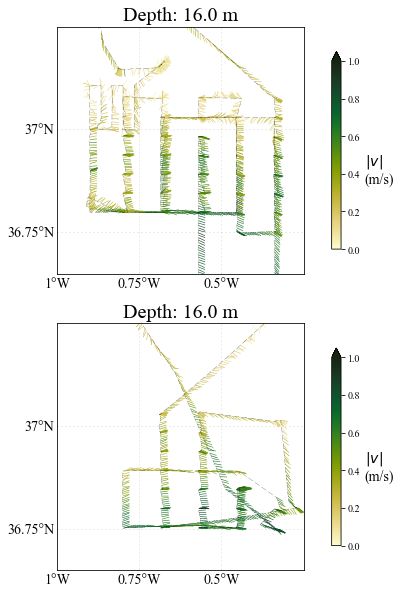

In [8]:
for idepth, depth in enumerate(adcp.depth[0:1]):
    
    figname = "ADCP_{}".format(str(idepth).zfill(4))
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(211)
    adcp.plot_adcp_quiver(m, depthindex=idepth, depth=depth, 
                          datemax=datetime.datetime(2014, 5, 28, 0, 0, 0))
    
    m.drawparallels(np.arange(36.5, coordinates2[3], 0.25), labels=[1, 0, 0, 0],
                   fontname='Times New Roman', fontsize=14,
                   linewidth=0.2, zorder=1, color=".6")
    m.drawmeridians(np.arange(-1, coordinates2[1], 0.25), labels=[0, 0, 0, 1],
                   fontname='Times New Roman', fontsize=14,
                    linewidth=0.2, zorder=1, color=".6")
    ax = plt.subplot(212)
    adcp.plot_adcp_quiver(m, depthindex=idepth, depth=depth, 
                          datemin=datetime.datetime(2014, 5, 28))
    
    m.drawparallels(np.arange(36.5, coordinates2[3], 0.25), labels=[1, 0, 0, 0],
                   fontname='Times New Roman', fontsize=14,
                   linewidth=0.2, zorder=1, color=".6")
    m.drawmeridians(np.arange(-1, coordinates2[1], 0.25), labels=[0, 0, 0, 1],
                   fontname='Times New Roman', fontsize=14,
                    linewidth=0.2, zorder=1, color=".6")
    #plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### Plot selected sections

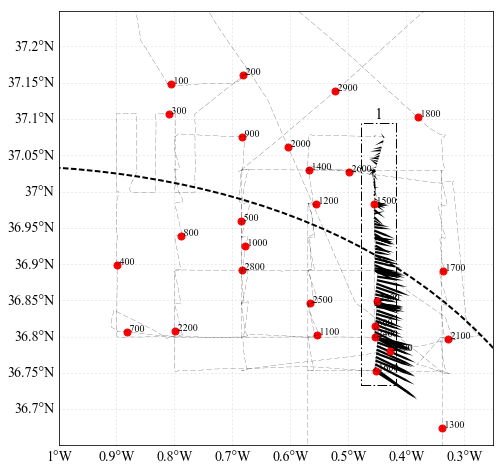

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
#NN1, NN2 = 1462, 1600
#NN1, NN2 = 1640, 1780
count = 0
for lon, lat in zip(adcp.lon[::100], adcp.lat[::100]):
    if lon <= coordinates2[1] and lon >= coordinates2[0] and lat <= coordinates2[3]:
        m.plot(lon, lat, "ro", markersize=7, latlon=True)
        llon, llat = m(lon, lat)
        plt.text(llon, llat, " " + str(count), ha="left")
    count += 100
    
NN1, NN2 = 1462, 1600
adcp.add_rectangle(NN1, NN2, m, label="1")

llon, llat = m(adcp.lon[NN1:NN2], adcp.lat[NN1:NN2])
m.plot(adcp.lon, adcp.lat, "k--", lw=.2, latlon=True)
plt.quiver(llon, llat, adcp.u[NN1:NN2,0], adcp.v[NN1:NN2,0], headwidth=1)
m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True)
m.drawparallels(np.arange(36.5, coordinates2[3], 0.05), labels=[1, 0, 0, 0],
                   fontname='Times New Roman', fontsize=14, 
                   linewidth=0.2, zorder=1, color=".6")
m.drawmeridians(np.arange(-1, coordinates2[1], 0.1), labels=[0, 0, 0, 1],
               fontname='Times New Roman', fontsize=14,
                linewidth=0.2, zorder=1, color=".6")
plt.show()
plt.close()

### Combined plot
Quiver plot and 2 north-south sections 

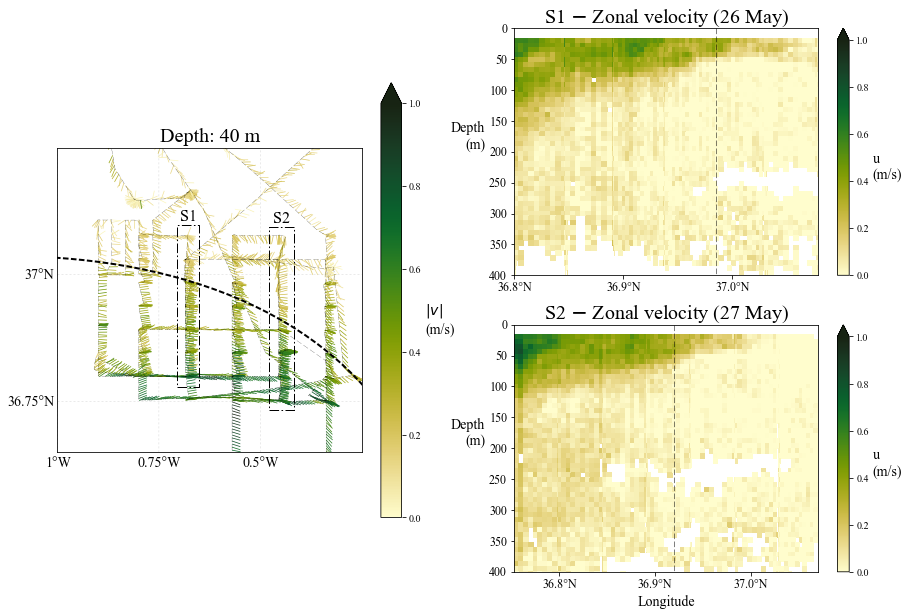

In [15]:
figname = "fig11"
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot2grid((2,2), (0,0), rowspan=2)

adcp.plot_adcp_quiver(m, depthindex=3, depth=40)
NN1, NN2 = 900, 1070
adcp.add_rectangle(NN1, NN2, m, label="S1")
NN1, NN2 = 1462, 1600
adcp.add_rectangle(NN1, NN2, m, label="S2")

m.drawparallels(np.arange(36.5, coordinates2[3], 0.25), labels=[1, 0, 0, 0],
               fontname='Times New Roman', fontsize=14,
               linewidth=0.2, zorder=1, color=".6")
m.drawmeridians(np.arange(-1, coordinates2[1], 0.25), labels=[0, 0, 0, 1],
               fontname='Times New Roman', fontsize=14,
                linewidth=0.2, zorder=1, color=".6")
m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True)

ax2 = plt.subplot2grid((2,2), (0,1))
NN1, NN2 = 900, 1070
adcp.make_velocity_section(adcp.lat[NN2:NN1:-1], adcp.depth, 
                      adcp.u[NN2:NN1:-1,:].T, frontlat=36.985,
                      title="S1 $-$ Zonal velocity (26 May)")

ax3 = plt.subplot2grid((2,2), (1,1))
NN1, NN2 = 1462, 1600
# 1640, 1780
adcp.make_velocity_section(adcp.lat[NN2:NN1:-1], adcp.depth, 
                      adcp.u[NN2:NN1:-1,:].T, frontlat=36.92,
                      xlabel="Longitude", title="S2 $-$ Zonal velocity (27 May)")

plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()